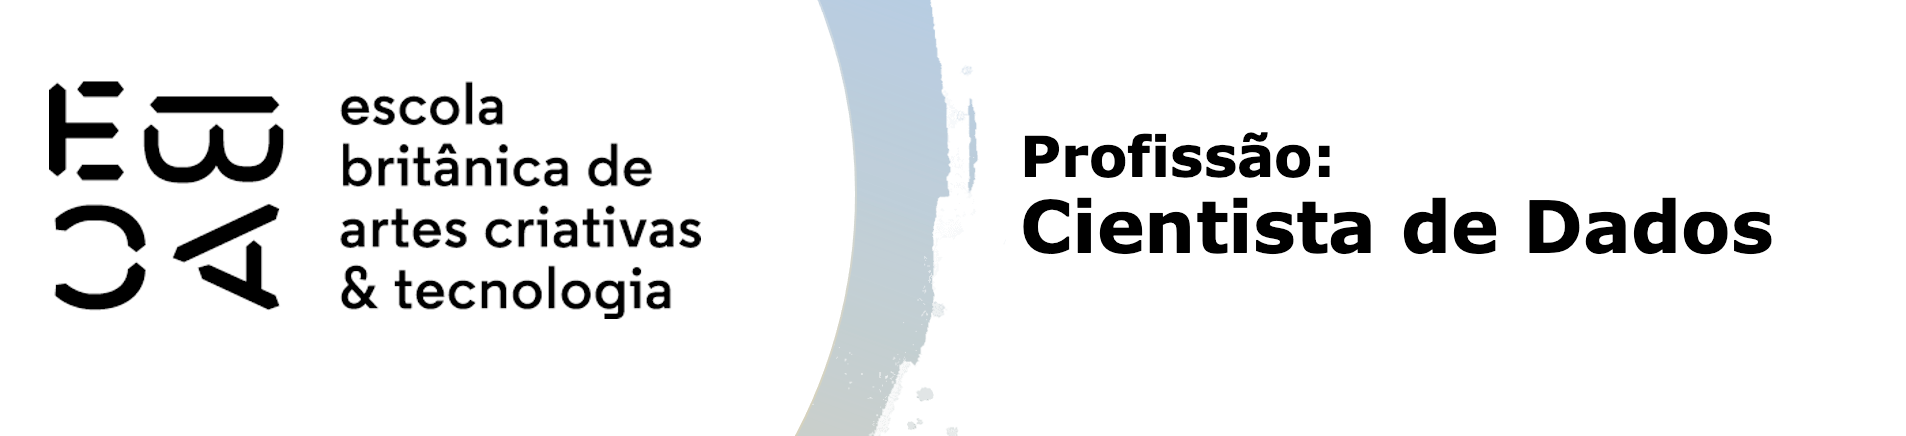

# Modulo 36 Atividade 01
#### João Paulo Costa

## Descritiva IV - Visualização de dados categorizados

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuração visual
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [3]:
# 2) Assegura tipos e cria coluna de data
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')

# 3) Cria variável de evento (Retorno>0)
df['evento'] = (df['Retorno'] > 0).astype(int)

# 4) Filtro de período (de 2020-01-01 em diante)
dt_ini = pd.Timestamp('2020-01-01')
df_2020 = df[df['Data Emissão'] >= dt_ini].copy()

print('Registros totais:', len(df))
print('Registros a partir de 2020-01-01:', len(df_2020))
df_2020.head(3)

Registros totais: 187646
Registros a partir de 2020-01-01: 86956


,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,evento
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido,0
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado,0
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos,0


In [4]:
# Tabela de proporção de evento por categoria
tab = (
    df_2020
    .groupby('categoria', dropna=False)['evento']
    .agg(qtd='count', eventos='sum', taxa_evento='mean')
    .sort_values('taxa_evento', ascending=False)
    .reset_index()
)
tab['taxa_evento'] = tab['taxa_evento'].round(4)
display(tab)

,categoria,qtd,eventos,taxa_evento
0,Restaurantes,2179,1626,0.7462
1,Alimentos,5050,3442,0.6816
2,Mercado,27558,13177,0.4782
3,Construção,16047,7523,0.4688
4,não definido,18407,6689,0.3634
5,Farmácia,10189,3582,0.3516
6,Auto posto,540,135,0.2500
7,Vestuário,1920,443,0.2307
8,Varejo,5066,701,0.1384


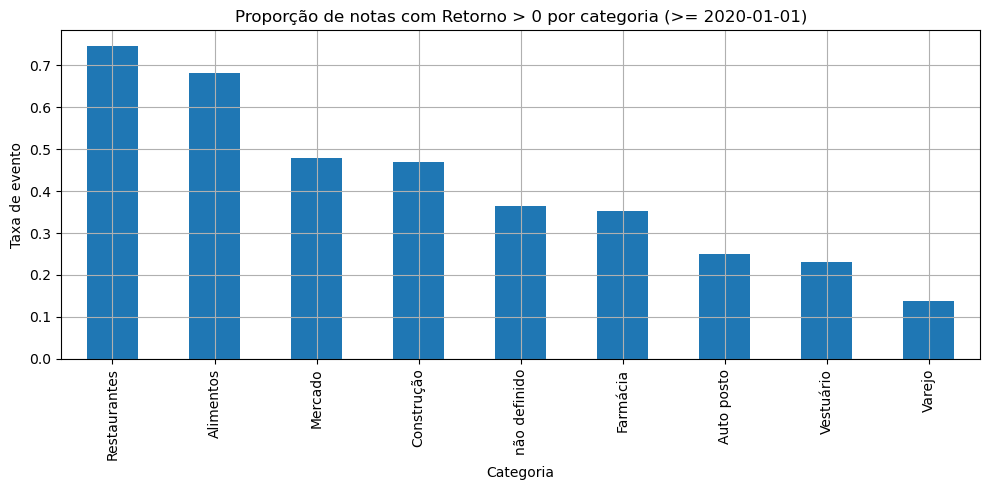

In [5]:
# Gráfico de barras da taxa de evento por categoria
ax = tab.plot(kind='bar', x='categoria', y='taxa_evento', legend=False)
ax.set_title('Proporção de notas com Retorno > 0 por categoria (>= 2020-01-01)')
ax.set_xlabel('Categoria')
ax.set_ylabel('Taxa de evento')
plt.tight_layout()
plt.show()

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [6]:
# Funções auxiliares para WOE/IV
def woe_iv_categorical(df, cat_col, y_col='evento', smooth=1.0):
    # Conta bons/maus por categoria
    grp = df.groupby(cat_col)[y_col].agg(['sum','count']).rename(columns={'sum':'bad','count':'total'})
    grp['good'] = grp['total'] - grp['bad']

    # Totais globais
    total_bad = grp['bad'].sum()
    total_good = grp['good'].sum()

    # Proporções com suavização
    grp['prop_bad'] = (grp['bad'] + smooth) / (total_bad + smooth * len(grp))
    grp['prop_good'] = (grp['good'] + smooth) / (total_good + smooth * len(grp))

    # WOE e IV
    grp['WOE'] = np.log(grp['prop_good'] / grp['prop_bad'])
    grp['IV_component'] = (grp['prop_good'] - grp['prop_bad']) * grp['WOE']
    iv = grp['IV_component'].sum()

    # Ajustes de apresentação
    out = grp[['bad','good','total','prop_bad','prop_good','WOE','IV_component']].reset_index()
    return out.sort_values('WOE', ascending=False), iv

In [7]:
woe_tab, iv_dummy = woe_iv_categorical(df_2020, 'categoria', y_col='evento', smooth=1.0)
woe_tab_display = woe_tab.copy()
woe_tab_display['prop_bad'] = woe_tab_display['prop_bad'].round(4)
woe_tab_display['prop_good'] = woe_tab_display['prop_good'].round(4)
woe_tab_display['WOE'] = woe_tab_display['WOE'].round(4)
woe_tab_display['IV_component'] = woe_tab_display['IV_component'].round(6)

display(woe_tab_display.head(20))

,categoria,bad,good,total,prop_bad,prop_good,WOE,IV_component
6,Varejo,701,4365,5066,0.0188,0.0879,1.5424,0.106636
7,Vestuário,443,1477,1920,0.0119,0.0298,0.9174,0.016399
1,Auto posto,135,405,540,0.0036,0.0082,0.8085,0.003666
3,Farmácia,3582,6607,10189,0.0960,0.1331,0.3269,0.012130
8,não definido,6689,11718,18407,0.1792,0.2360,0.2754,0.015647
2,Construção,7523,8524,16047,0.2016,0.1717,-0.1603,0.004787
4,Mercado,13177,14381,27558,0.3530,0.2897,-0.1978,0.012532
0,Alimentos,3442,1608,5050,0.0922,0.0324,-1.0460,0.062579
5,Restaurantes,1626,553,2179,0.0436,0.0112,-1.3625,0.044186


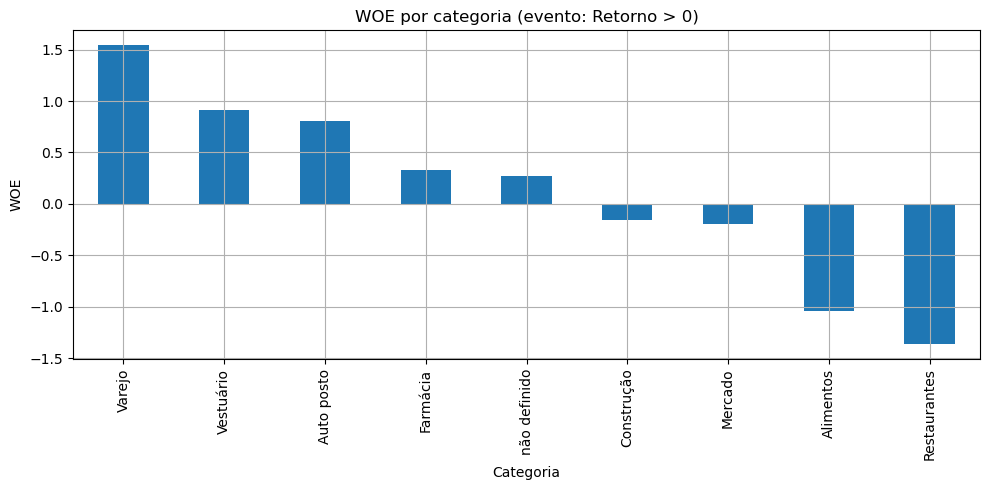

In [8]:
# Gráfico de WOE (top N categorias para facilitar leitura)
topN = min(20, len(woe_tab_display))
ax = woe_tab_display.head(topN).plot(kind='bar', x='categoria', y='WOE', legend=False)
ax.set_title('WOE por categoria (evento: Retorno > 0)')
ax.set_xlabel('Categoria')
ax.set_ylabel('WOE')
plt.tight_layout()
plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [9]:

IV_categoria = woe_tab['IV_component'].sum()
print(f"Information Value (IV) da variável 'categoria': {IV_categoria:.6f}")

# Faixas de interpretação usuais (Regra geral)
interpretacao = (
    "Regras de bolso para IV:\n"
    "• < 0.02: Baixo poder preditivo\n"
    "• 0.02 – 0.1: Fraco\n"
    "• 0.1 – 0.3: Médio\n"
    "• 0.3 – 0.5: Forte\n"
    "• > 0.5: Muito forte (verificar risco de sobreajuste)"
)
print(interpretacao)

Information Value (IV) da variável 'categoria': 0.278561
Regras de bolso para IV:
• < 0.02: Baixo poder preditivo
• 0.02 – 0.1: Fraco
• 0.1 – 0.3: Médio
• 0.3 – 0.5: Forte
• > 0.5: Muito forte (verificar risco de sobreajuste)


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


 **O que observei: <br> - A taxa de `Retorno > 0` varia de forma relevante entre as categorias de estabelecimento. Isso indica que `categoria` é uma variável <br>informativa para diferenciar notas com/sem retorno.<br> - O WOE mostrou sinais positivos para categorias onde a proporção de “bons” (sem evento) é maior e sinais negativos onde a proporção de “maus” <br>(com evento) é maior — coerente com o conceito.<br> - O **IV** calculado para `categoria` reforça o seu poder discriminativo (ver valor acima e compare com as faixas de referência)**.